# Problem description

Semantic segmentation
Open-set recognition
Fusion of these methods using Bayesian probability framework

# Datasets

The model is trained on the Lost and Found and Cityscapes datasets, and evaluated on the Lost and Found test dataset

1. **Lost and Found**
- The Lost and Found dataset contains 2104 annotated frames gathered from 112 video sequences: http://wwwlehre.dhbw-stuttgart.de/~sgehrig/lostAndFoundDataset/index.html
- The segmentation mask contains a pixel-level annotation distinguishing 3 classes: 'road', 'off-road' and 'small obstacle'.
- The test set contains 1200 images taken in varying road conditions (illumination, distance to obstacles, road texture, etc.).

2. **Cityscapes**
- The cityscapes dataset contains 5000 annotated images of urban areas: https://www.cityscapes-dataset.com/dataset-overview/#class-definitions
- There are 30 different class labels that model is able to detect, grouped in 8 big categories: 'flat', 'human', 'vehicle', 'construction', 'object', 'nature', 'sky', 'void'. Out of these, the objects representing the unexpected obstacles laying on the road, would probably be classified as 'void.static'.
- The test set contains 1525 annotated images.

## Exploratory Data Analysis

In [220]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import os
import shutil
from packaging import version
import sklearn.metrics
import PIL.Image as Image

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.10.1


In [2]:
# test if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
print(tf.config.experimental.get_device_details(physical_devices[0]))
logical_devices = tf.config.list_logical_devices('GPU')
print(logical_devices)
GPU_NAME = logical_devices[0].name
print("logical GPU name = ", GPU_NAME)

{'device_name': 'NVIDIA GeForce RTX 3060 Laptop GPU', 'compute_capability': (8, 6)}
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
logical GPU name =  /device:GPU:0


In [459]:
def download_data():
    (lost_and_found_test_ds, lost_and_found_train_ds), info = tfds.load(
        'lost_and_found/semantic_segmentation',
        split=["test", "train"],
        with_info=True)
    print(info.features)

    return lost_and_found_train_ds, lost_and_found_test_ds

def load_data(img_size=512):
    train_img_ds = tf.keras.utils.image_dataset_from_directory(
        "datasets/lost_and_found/train/image",
        image_size=(1024, 2048),
        labels=None,
        shuffle=None,
        color_mode='rgb',
        batch_size=None,
        crop_to_aspect_ratio=True
    ).map(lambda img: tf.image.resize(images=img, size=[img_size, 2*img_size]) / 255)

    train_mask_ds = tf.keras.utils.image_dataset_from_directory(
        "datasets/lost_and_found/train/mask",
        image_size=(1024, 2048),
        labels=None,
        shuffle=None,
        color_mode='grayscale',
        batch_size=None,
        crop_to_aspect_ratio=True
    ).map(lambda img: tf.image.resize(images=img, size=[img_size, 2*img_size]) / 255)

    test_img_ds = tf.keras.utils.image_dataset_from_directory(
        "datasets/lost_and_found/test/image",
        image_size=(1024, 2048),
        labels=None,
        shuffle=None,
        color_mode='rgb',
        batch_size=None,
        crop_to_aspect_ratio=True
    ).map(lambda img: tf.image.resize(images=img, size=[img_size, 2*img_size]) / 255)

    test_mask_ds = tf.keras.utils.image_dataset_from_directory(
        "datasets/lost_and_found/test/mask",
        image_size=(1024, 2048),
        labels=None,
        shuffle=None,
        color_mode='grayscale',
        batch_size=None,
        crop_to_aspect_ratio=True
    ).map(lambda img: tf.image.resize(images=img, size=[img_size, 2*img_size]) / 255)

    train_ds = tf.data.Dataset.zip((train_img_ds, train_mask_ds))
    test_ds = tf.data.Dataset.zip((test_img_ds, test_mask_ds))
    return train_ds, test_ds

In [460]:
IMG_SIZE=256
train_ds, test_ds = load_data(img_size=(IMG_SIZE))

Found 1036 files belonging to 1 classes.
Found 1036 files belonging to 1 classes.
Found 1203 files belonging to 1 classes.
Found 1203 files belonging to 1 classes.


In [449]:
train_ds.element_spec

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None))

In [450]:
print("Train dataset size: ", train_ds.cardinality().numpy())
print("Test dataset size: ", test_ds.cardinality().numpy())

Train dataset size:  1036
Test dataset size:  1203


The annotations of each pixel in the segmentation mask represent:
- 0: off-road
- 1: on-road
- otherwise: small-obstacle

> **Instance segmentation:**
Each obstacle laying on the road surface has a different color mapping (gray level greater than 1).
The further away the obstacle, the smaller the value of its associated label.

In [345]:
def display_color_histogram(img):
    plt.figure()
    plt.imshow(img)
    channels = cv2.split(img)
    colors = ("b", "g", "r")
    plt.figure()
    plt.title("Color Histogram")
    plt.xlabel("Bins")
    plt.ylabel("# of pixels")

    for (channel, color) in zip(channels, colors):
        hist = cv2.calcHist([channel], [0], None, [256], [0, 256])
        plt.plot(hist, color=color)
        plt.xlim([0, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


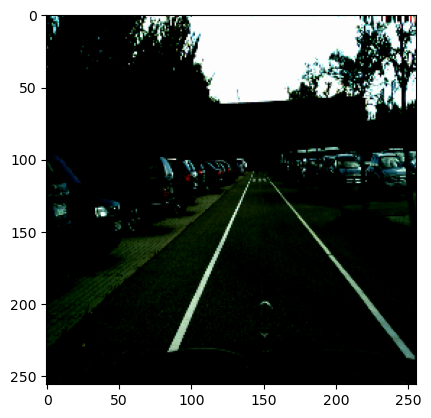

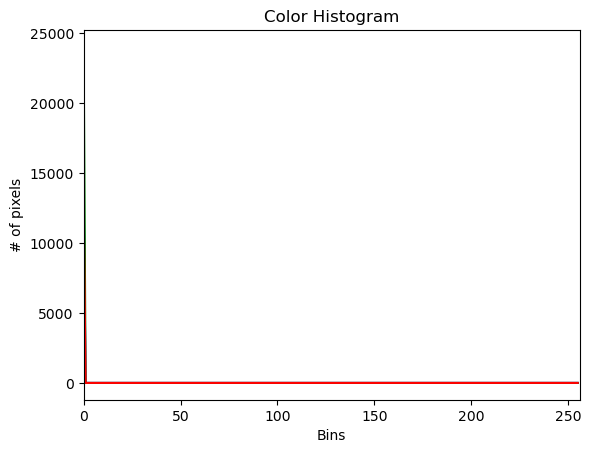

In [451]:
train_it = train_ds.as_numpy_iterator()
sample_img, sample_mask = train_it.next()
display_color_histogram(sample_img)

The images are predominantly bright with high exposure (daytime pictures). The peaks around the middle region for gray levels around 128 are due to the color of the road surface, which covers a large part of the image.

In [298]:
def encode_color_label(pixel):
    # use RGB color encoding
    if pixel == 0:
        return [0, 0, 0]
    if pixel == 1:
        return [255, 0, 0]
    return [0, 255, 0]


def convert_to_color_mask(mask):
    height, width, _ = mask.shape
    color_mask = np.array(list(map(encode_color_label, mask.flatten())))
    return color_mask.reshape((height, width, 3))

(256, 256, 3)


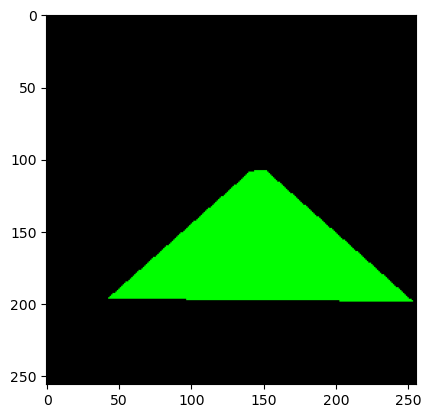

In [452]:
mask = convert_to_color_mask(sample_mask)
print(mask.shape)
plt.imshow(mask)

## View the images on Tensorboard (port 6006)

In [29]:
# % load_ext tensorboard
# # % reload_ext tensorboard

In [30]:
# # Sets up a timestamped log directory.
# logs_train_dir = "./logs/train_data"
#
# # Clear out any prior log data.
# shutil.rmtree(logs_train_dir)
# os.makedirs(logs_train_dir, exist_ok=True)
#
# # Creates a file writer for the log directory.
# file_writer = tf.summary.create_file_writer(logs_train_dir)

In [31]:
# # Using the file writer, log the reshaped image.
# with file_writer.as_default():
#     for i in range(0, 3):
#         id = str(lost_and_found_train_df.image_id[i])
#         img = lost_and_found_train_df.image_left[i]
#         img = np.expand_dims(img, 0)
#         img = tf.convert_to_tensor(img)
#         tf.summary.image(id, img, step=0)
#         mask = lost_and_found_train_df.segmentation_label[i]
#         mask = convert_to_color_mask(mask)
#         mask = np.expand_dims(mask, 0)
#         mask = tf.convert_to_tensor(mask)
#         tf.summary.image(id + "_mask", mask, step=0)
#
# % tensorboard --logdir {logs_train_dir}

# Building the model

Semantic Segmentation model (SS):
- based on the DeepLabv3+ semantic segmentation model using ResNet50 as the backbone
- DeepLabv3+ extends DeepLabv3 by adding an encoder-decoder structure and an ASPP (Atrous Spatial Pyramid Pooling) layer

> **ASPP**
To reduce nr of filter weights as the sampling rate becomes larger, and to integrate multi-scale feature information using a conv kernel with larger dilation rate for detecting large objects and smaller dilation rate for smaller objects.

In [453]:
def conv_block(input, name, filters=64, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
    x = layers.Conv2D(filters=filters,
                      kernel_size=kernel_size,
                      dilation_rate=dilation_rate,
                      padding=padding,
                      use_bias=use_bias,
                      kernel_initializer=keras.initializers.he_normal,
                      name=name)(input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

### Kernel weight initializers

> **Uniform distribution initializer:**
- weights are selected from the range [-1/sqrt(fan_in), 1/sqrt(fan_in)];
- used with sigmoid activation function.
> **Xavier (Glorot) initializer:**
- for Xavier Normal the weights are selected from normal distribution with mean 0 and std dev sqrt(2/fan_in) + fan_out;
- used with sigmoid activation function.
> **He initializer:**
- for He Normal the weights are selected from normal distribution with mean 0 and std_dev = sqrt(2/fan_in);
- used with ReLU activation function.

### Batch normalization

= standardizes the inputs to a layer for every mini-batch
The distribution of inputs to layers in the network could change after each mini-batch when the weights are updated => _internal covariate shift_
Could be applied to the activations of a prior layer or inputs of the current layer.
> -> accelerate training
> -> provides regularization (reduce generalization error)

In [300]:
def aspp(input):
    _, input_height, input_width, _ = input.shape
    x = layers.AveragePooling2D(pool_size=(input_height, input_width), name="aspp_decoder")(input)
    x = conv_block(x, kernel_size=1, use_bias=True, name="aspp_conv_1")
    output_height = input_height // x.shape[1]
    output_width = input_width // x.shape[2]
    output_pool = layers.UpSampling2D(size=(output_height, output_width), interpolation='bilinear',
                                      name="aspp_encoder")(x)

    conv_1 = conv_block(input, kernel_size=1, dilation_rate=1, name="aspp_inc_conv_1")
    conv_4 = conv_block(input, kernel_size=3, dilation_rate=4, name="aspp_inc_conv_4")
    conv_8 = conv_block(input, kernel_size=3, dilation_rate=8, name="aspp_inc_conv_8")
    conv_12 = conv_block(input, kernel_size=3, dilation_rate=12, name="aspp_inc_conv_12")

    x = layers.Concatenate(axis=-1)([output_pool, conv_1, conv_4, conv_8, conv_12])
    output = conv_block(x, kernel_size=1, name="aspp")
    return output

> Before feeding the input to a 1x1 convolutional layer, its dimension reduced using a global average pooling layer (downsampling), and later it is upsampled using a bilinear interpolation.
The inception layer containing 4 convolutional layers with different kernel sizes and different dilation rates.
Finally, the output of the inception layer is concatenated with the output of the upsampling layer and it is fed to another 1x1 conv layer.

**Inception layer**
Allows the internal layers to use different filter sizes depending on which is better for extracting the relevant information from the input.

**Atrous/Dilated convolution**
To increase perceptual field to retain more spatial information about the small object.
The original dilation rates (6,12,18) have been reduced to just (4,8,12).

**Global Average Pooling**
Downsampling (extreme dimensionality reduction): h x w x d => 1 x 1 x d  (h x w feature map is reduced to 1 number, their average)
Generalization: reduce the number of trainable params in the model to avoid overfitting
Good for object localization: retains spatial information expressed as a heat map (class activation map) which indicates the regions that are more important for the detection task

In [440]:
def preprocessing_layer(input, img_size):
    prep_input = keras.layers.CenterCrop(img_size, img_size)(input)
    prep_input = keras.layers.Rescaling(1. / 255, offset=0.0)(prep_input)
    return prep_input

In [461]:
def deeplab_v3_plus(nr_classes, img_dim):
    input = keras.Input(shape=img_dim, name="input")
    # preprocessed_input = preprocessing_layer(input, crop_dim)
    resnet50 = keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=input)
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = aspp(x)
    # upsample the obtained data after ASPP by a factor of 4
    input_height = img_dim[0] // (x.shape[1] * 4)
    input_width = img_dim[1] // (x.shape[2] * 4)
    input_a = layers.UpSampling2D(size=(input_height, input_width), interpolation="bilinear", name="backbone_encoder")(
        x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = conv_block(input_b, filters=16, kernel_size=1, name="resnet50_backbone_2")

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = conv_block(x, name="resnet50_conv_3_1")
    x = conv_block(x, name="resnet50_conv_3_2")

    x = layers.UpSampling2D(size=(img_dim[0] // x.shape[1], img_dim[1] // x.shape[2]), interpolation="bilinear",
                            name="resnet_decoder")(x)
    # put together the input and the output layers to create the final model
    output = layers.Conv2D(filters=nr_classes, kernel_size=(1, 1), padding="same", name="output")(x)
    return keras.Model(inputs=input, outputs=output)

In [463]:
ss_model = deeplab_v3_plus(img_dim=(IMG_SIZE, 2*IMG_SIZE, 3), nr_classes=1)
ss_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 518, 3)  0           ['input[0][0]']                  
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

## Prepare dataset for training

In [464]:
from tensorflow.python.data import AUTOTUNE

def split_dataset(dataset, validation_size=100):
    val_ds = dataset.take(validation_size)
    train_ds = dataset.skip(validation_size)
    return val_ds, train_ds

def prepare_batches(dataset, batch_size=32):
    dataset = dataset.shuffle(buffer_size=64)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

In [465]:
BATCH_SIZE = 4

train_and_val_ds, test_ds = load_data(img_size=IMG_SIZE)
val_ds, train_ds = split_dataset(train_and_val_ds, validation_size=100)

print("Train size: ",end=" ")
tf.print(train_ds.cardinality())
print("Validation size: ",end=" ")
tf.print(val_ds.cardinality())

train_ds_batches = prepare_batches(train_ds, batch_size=BATCH_SIZE)
val_ds_batches = prepare_batches(val_ds, batch_size=BATCH_SIZE)

Found 1036 files belonging to 1 classes.
Found 1036 files belonging to 1 classes.
Found 1203 files belonging to 1 classes.
Found 1203 files belonging to 1 classes.
Train size:  936
Validation size:  100


# Training the model

**Loss function**: Categorical crossentropy (for multi-class classification, following a Softmax activation function)
**Optimizer**: Adam optimizer
> **Why Adam?**
> Adam = Adaptive Moment Estimation
> Computes the moving average of the gradient and adapts the learning rate based on the avg of first moment(mean) and the avg of the second moment(variance).
> SGD maintains a single learning rate for all weight updates, which doesn't change during training.
> Adam vs SGD: Adam converges faster, but SGD generalizes better.

In [466]:
loss = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam(learning_rate=0.01)

ss_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)

filepath = "models/ss_model.h5"

earlystopper = keras.callbacks.EarlyStopping(patience=3, verbose=1)

checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

history = ss_model.fit(train_ds_batches,
                       epochs=5,
                       validation_data=val_ds_batches,
                       validation_steps=2,
                       callbacks=callbacks_list)

Epoch 1/5
234/234 [==============================] - ETA: 0s - loss: 0.1383 - accuracy: 0.8325
Epoch 1: val_loss improved from inf to 0.21109, saving model to models\ss_model.h5
234/234 [==============================] - 35s 125ms/step - loss: 0.1383 - accuracy: 0.8325 - val_loss: 0.2111 - val_accuracy: 0.8537
Epoch 2/5
234/234 [==============================] - ETA: 0s - loss: 0.1179 - accuracy: 0.8349
Epoch 2: val_loss improved from 0.21109 to 0.16727, saving model to models\ss_model.h5
234/234 [==============================] - 30s 121ms/step - loss: 0.1179 - accuracy: 0.8349 - val_loss: 0.1673 - val_accuracy: 0.8406
Epoch 3/5
234/234 [==============================] - ETA: 0s - loss: 0.1167 - accuracy: 0.8349
Epoch 3: val_loss improved from 0.16727 to 0.14811, saving model to models\ss_model.h5
234/234 [==============================] - 31s 123ms/step - loss: 0.1167 - accuracy: 0.8349 - val_loss: 0.1481 - val_accuracy: 0.8343
Epoch 4/5
234/234 [==============================] - ETA

In [467]:
def display_results(history):
    plt.figure()
    metrics = ['loss', 'accuracy']

    for metric in metrics:
        plt.plot(history.history[metric], label='Training ' + metric)
        plt.plot(history.history['val_' + metric], label='Validation ' + metric)
        plt.title(metric)
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
        plt.show()

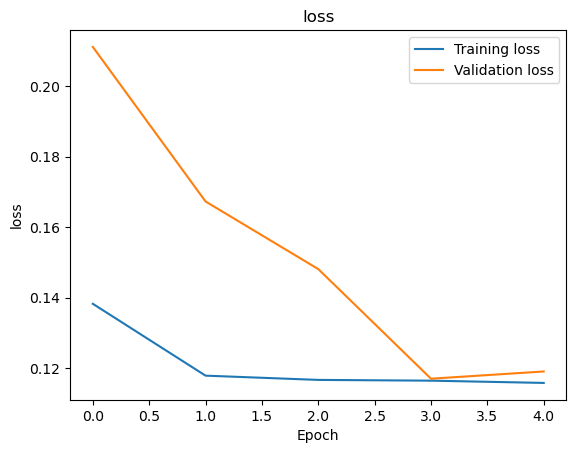

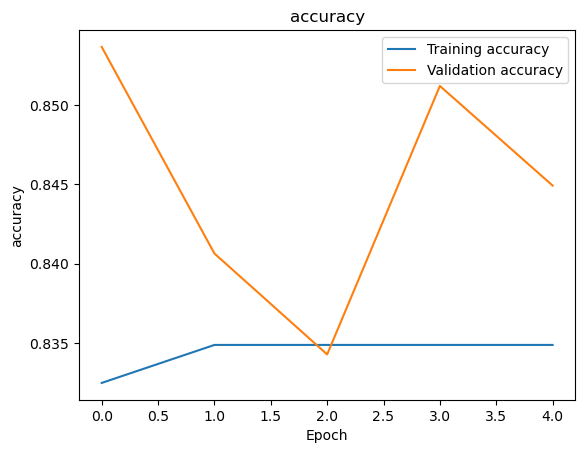

In [468]:
display_results(history)

In [491]:
test_batches_ds = prepare_batches(test_ds, BATCH_SIZE)
test_it = test_batches_ds.as_numpy_iterator()

In [485]:
def show_image_pairs(a, b, n):
    for i in range(0, n):
        fig = plt.figure()
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.imshow(a[i])
        save_img(a[i]*255, "output/model_ss/input_{}.jpg".format(i))
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.imshow(b[i]*255)
        save_img(b[i], "output/model_ss/output_{}.jpg".format(i))

def save_img(img_arr, file_name):
    img_arr = img_arr.astype(np.uint8)
    if img_arr.ndim == 3 and img_arr.shape[2] == 1:
        img_arr = np.squeeze(img_arr, axis=2)
    img = Image.fromarray(img_arr)
    img.save(file_name)

In [493]:
def predict_mask(nr_examples):
    for i in range(nr_examples):
        test_img, test_mask = test_it.next()
        predicted_mask = ss_model.predict(test_img)
        show_image_pairs(test_img, predicted_mask, BATCH_SIZE)

1/1 [==============================] - 0s 33ms/step


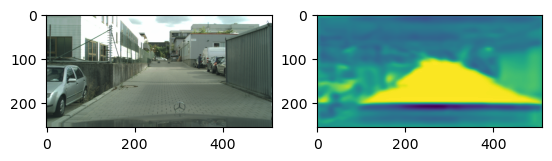

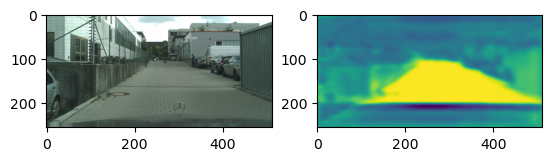

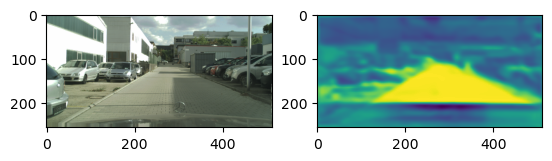

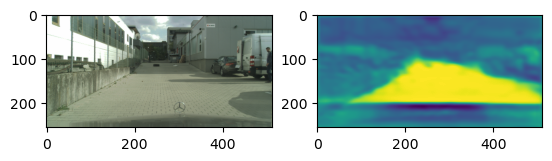

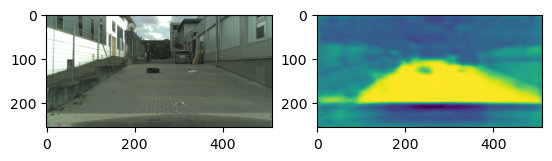

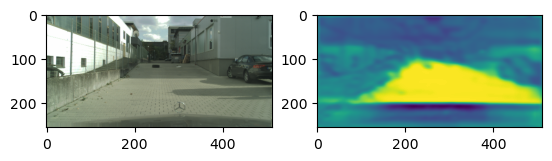

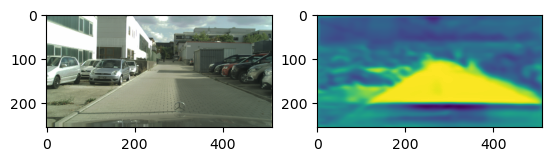

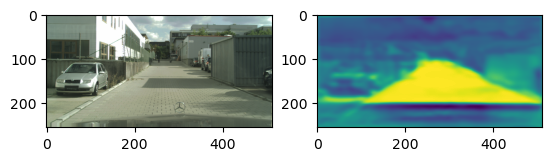

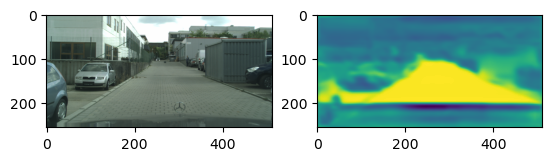

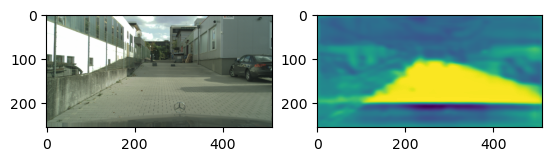

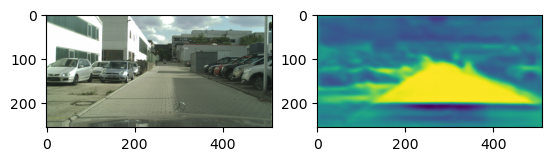

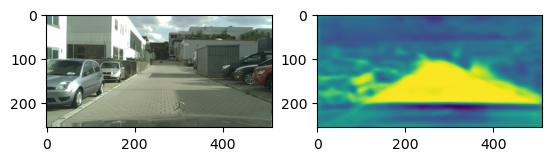

In [494]:
predict_mask(3)